# EEG Full Pipeline
This notebook implements an **end‑to‑end EEG analysis and visualisation pipeline** that follows the block‑diagrams illustrated below.

![data_analysis.png](figures/data_analysis.png)

![full_pipeline](figures/full_pipeline.png)


In [1]:

import os, glob, pathlib, warnings, json, itertools, pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne import compute_rank

# from mne.time_frequency import psd_welch
mne.viz.set_browser_backend('matplotlib')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

# plotting inline
%matplotlib inline

DATA_DIR = pathlib.Path("./experiment_data")
FIG_DIR  = pathlib.Path("./figures")
FIG_DIR.mkdir(exist_ok=True)
RANDOM_STATE = 42
warnings.filterwarnings('ignore')
print(f"MNE version: {mne.__version__}")


Using matplotlib as 2D backend.
MNE version: 1.8.0


Using raw file: experiment_data/Subject_03/EEG/Fatigue_03_cleaned_raw.fif
Opening raw data file experiment_data/Subject_03/EEG/Fatigue_03_cleaned_raw.fif...
    Range : 0 ... 484914 =      0.000 ...  1894.195 secs
Ready.
Reading 0 ... 484914  =      0.000 ...  1894.195 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


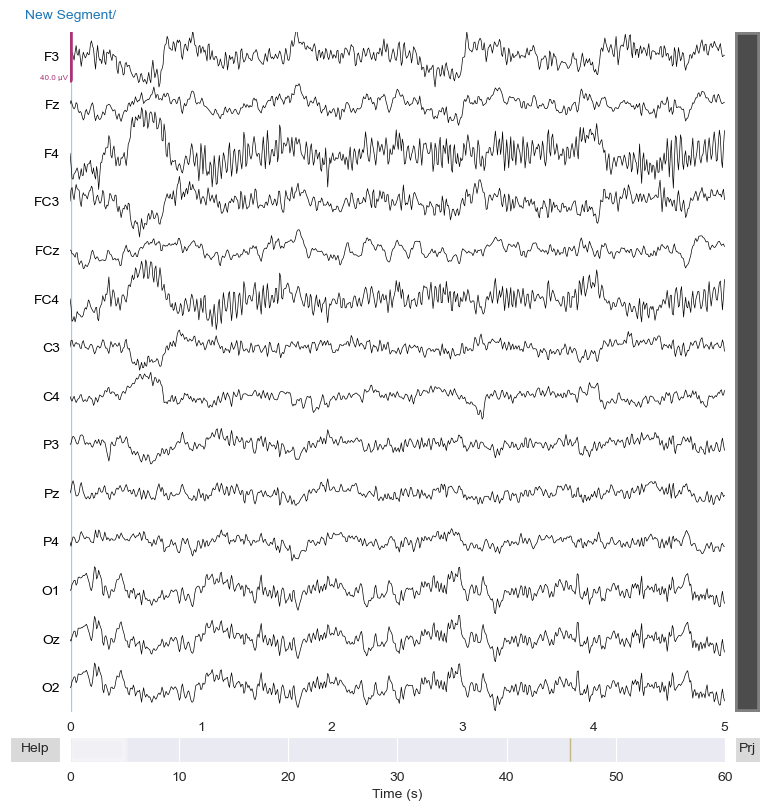

In [2]:
# ---------------------------------------------------------------
# Locate a raw FIF/EDF/... file. The first match in ./data is used
# ---------------------------------------------------------------
raw_files = sorted([*DATA_DIR.glob('**/*.[fF][iI][fF]')] + 
                   [*DATA_DIR.glob('**/*.edf')])

if not raw_files:
    # Fallback to MNE sample data so the notebook remains runnable
    print("No raw files found in ./data – downloading MNE sample dataset.")
    sample_path = mne.datasets.sample.data_path()
    raw_fname = sample_path + '/MEG/sample/sample_audvis_raw.fif'
else:
    raw_fname = str(raw_files[0])

print(f"Using raw file: {raw_fname}")
raw = mne.io.read_raw(raw_fname, preload=True)
raw.crop(0, 60)  # work on first minute to speed things up
raw.set_eeg_reference('average', projection=True)
raw.plot(n_channels=30, duration=5, title='Raw (first 5 s)', show=True, block=False);


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Aggregating Welch estimates (median) before plotting...


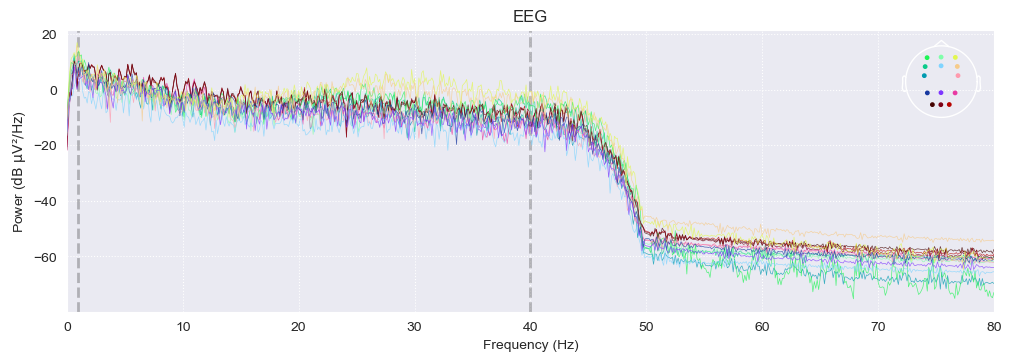

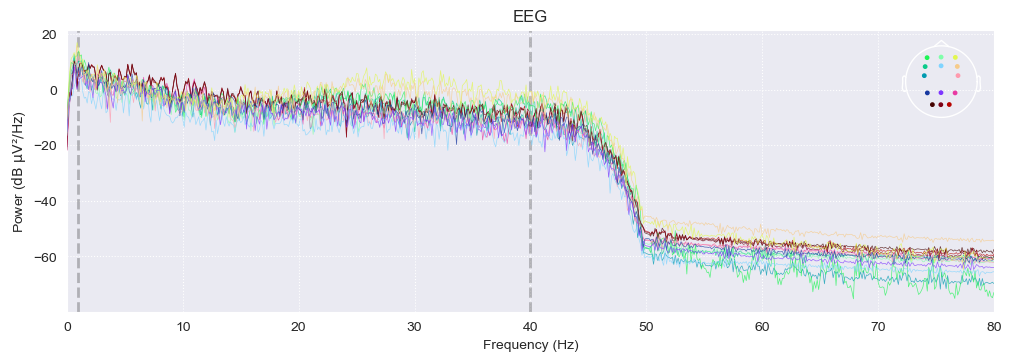

In [3]:
# --------- Per‑channel PSD BEFORE any processing ----------
raw.compute_psd(fmax=80, average=False).plot()

### Why we did this
Sanity‑checks on the unprocessed signal catch gross recording issues (dead channels, line‑noise spikes, etc.) early, preventing wasted compute downstream.

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']


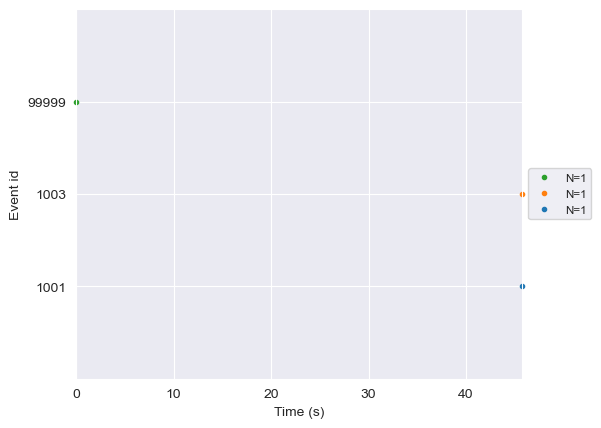

Original event mapping: {'New Segment/': 99999, 'Response/R  1': 1001, 'Response/R  3': 1003}


In [4]:
# --------- Visualise events BEFORE epoching ----------
events, event_id_orig = mne.events_from_annotations(raw)
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp);
print('Original event mapping:', event_id_orig)

In [5]:
# ----------------------- Epoching ----------------------------
rename_map = {
    "Response/R  1": "stimulus",
    "Response/R  3": "answer",
}
event_id = {new: event_id_orig.get(old) for old, new in rename_map.items() if old in event_id_orig}
if len(event_id) < 2:
    # If the expected keys are missing, fall back to the original mapping
    event_id = event_id_orig

tmin, tmax = -0.2, 0.8  # 200 ms pre‑stim → 800 ms post‑stim
epochs = mne.Epochs(
    raw, events, event_id, tmin=tmin, tmax=tmax,
    baseline=(None, 0), preload=True, event_repeated='merge'
)
print(epochs)

Not setting metadata
2 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 2 events and 257 original time points ...
0 bad epochs dropped
<Epochs | 2 events (all good), -0.199 – 0.801 s (baseline -0.199 – 0 s), ~85 kB, data loaded,
 'stimulus': 1
 'answer': 1>


combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


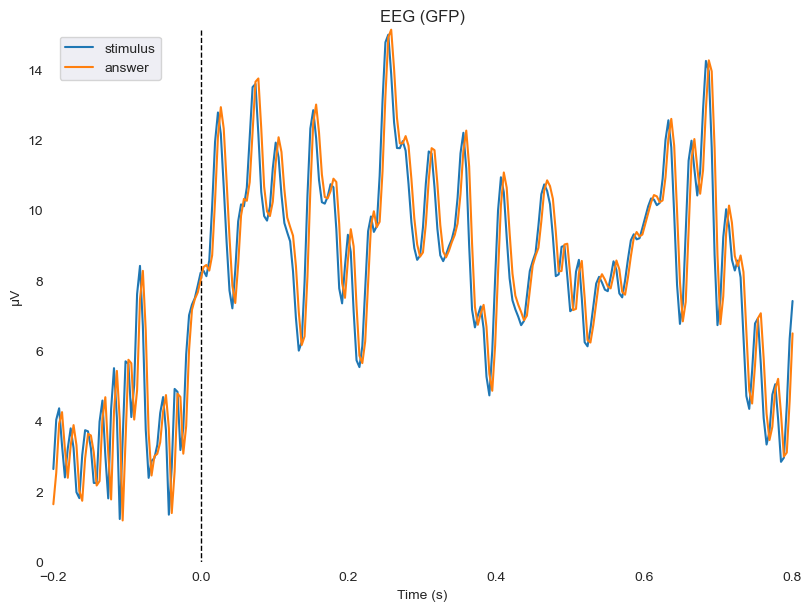

In [6]:
# --------- AFTER epoching: ERP overview ----------
evoked_dict = {cond: epochs[cond].average() for cond in event_id}
_ = mne.viz.plot_compare_evokeds(evoked_dict, picks='eeg');

### Why we did this
Epoching aligns all trials to a common temporal reference, enabling condition‑specific averaging (ERPs) and statistics across participants & sessions.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


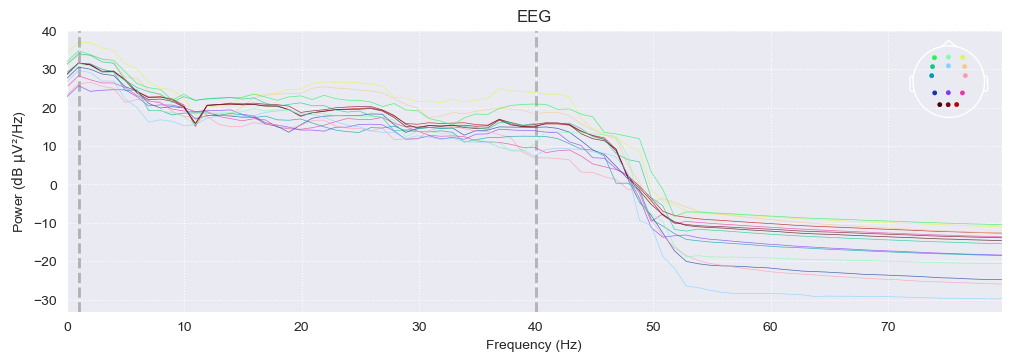

In [7]:
# --------- BEFORE filtering: PSD -----------
epochs.plot_psd(fmax=80, area_mode=None);

In [8]:
# ------------------ Band‑pass + Notch ------------------------
raw_notch = raw.copy().notch_filter(freqs=[50, 100], fir_design='firwin')
epochs_filt = (
    mne.Epochs(raw_notch, events, event_id, tmin, tmax,
               preload=True, baseline=None)
        .filter(l_freq=1., h_freq=40., fir_design='firwin')
)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 2 events and 257 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


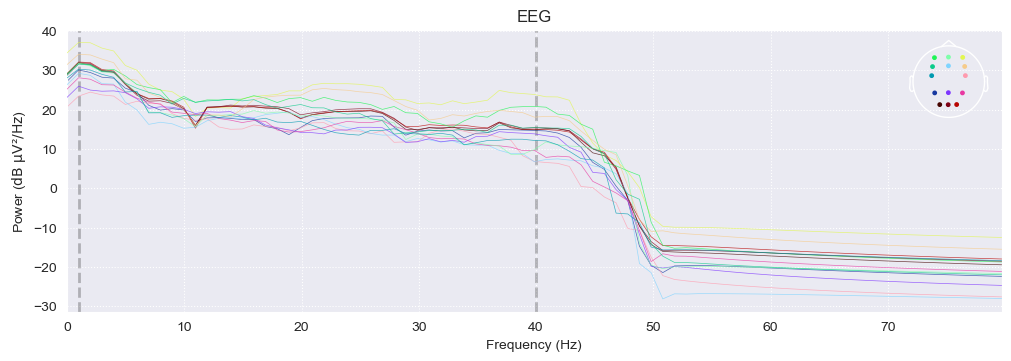

In [9]:
# --------- AFTER filtering: PSD -----------
epochs_filt.plot_psd(fmax=80, area_mode=None);

### Why we did this
Band‑passing retains neural rhythms of interest (1–40 Hz) while discarding slow drift & high‑frequency muscle artifacts. A 50 Hz notch removes mains interference common in EU power supplies.

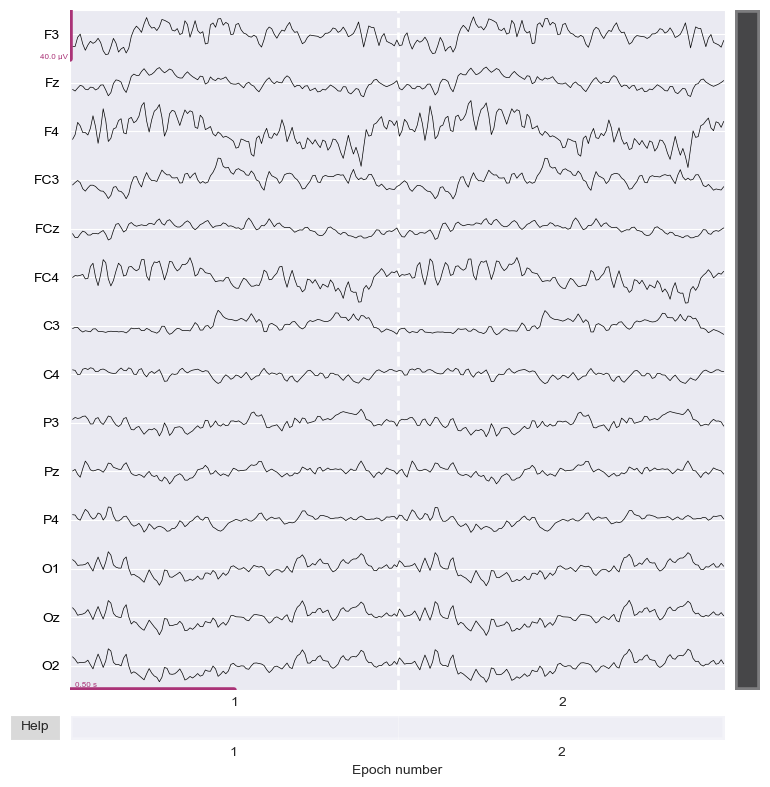

In [10]:
# -------- BEFORE ICA: sample epoch for eye‑blink vis ----------
epochs_filt.plot(n_epochs=5, n_channels=30);

In [11]:
# -------------------------- ICA ------------------------------
def run_ica_cleaning(epochs_filt):
    # computing rank
    rank_dict   = compute_rank(epochs_filt, tol="auto")
    n_comp_eeg  = int(rank_dict["eeg"])

    # fitting full-rank ICA
    ica = ICA(
        n_components=n_comp_eeg,
        method="fastica",
        random_state=RANDOM_STATE
    )
    ica.fit(epochs_filt)

    # automatically mark ocular components using a frontal proxy

    eog_inds, ecg_inds = [], []
    try:
        eog_inds, _ = ica.find_bads_eog(
            epochs_filt,
            ch_name="Fz",
            threshold=3.0
        )
    except RuntimeError:   # triggered only if "Fz" missing
        pass

    # skipping ECG
    ica.exclude = list(set(eog_inds + ecg_inds))
    print(f"Auto-marked ICA components: {ica.exclude}")


    # 4) fallback artefact rejection if nothing was flagged
    if not ica.exclude:
        epochs_filt.drop_bad(reject={"eeg": 150e-6})  # 150 µV P-P

    return epochs_filt.copy(), ica, n_comp_eeg

# 5) apply the cleaning
epochs_clean, ica, n_comp_eeg = run_ica_cleaning(epochs_filt)
ica.apply(epochs_clean)


Computing rank from data with rank=None
    Using tolerance 1.2e-13 (2.2e-16 eps * 14 dim * 40  max singular value)
    Estimated rank (eeg): 13
    EEG: rank 13 computed from 14 data channels with 1 projector
Fitting ICA to data using 14 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 13 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 0.1s.
Using EOG channel: Fz
    Applying projection operator with 1 vector (pre-whitener application)
Auto-marked ICA components: []
0 bad epochs dropped
Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (13 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components


<Epochs | 2 events (all good), -0.199 – 0.801 s (baseline off), ~85 kB, data loaded,
 'stimulus': 1
 'answer': 1>

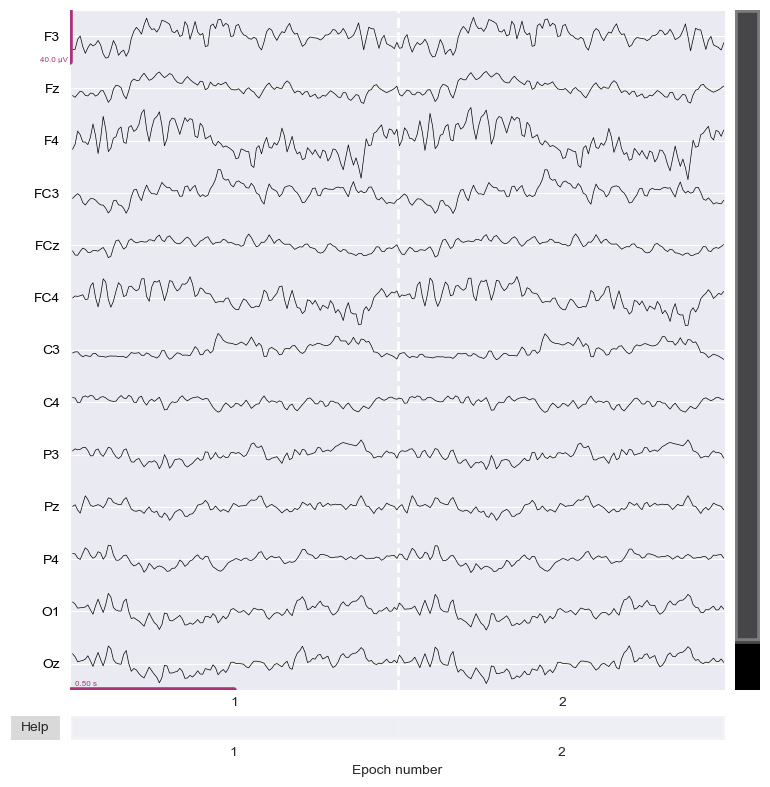

In [12]:
# -------- AFTER ICA cleaning ----------
epochs_clean.plot(n_epochs=5, n_channels=n_comp_eeg);

### Why we did this
ICA separates mixed sensor signals into statistically independent sources, allowing us to zero‑out components dominated by blink, cardiac or movement artifacts while preserving neural activity.

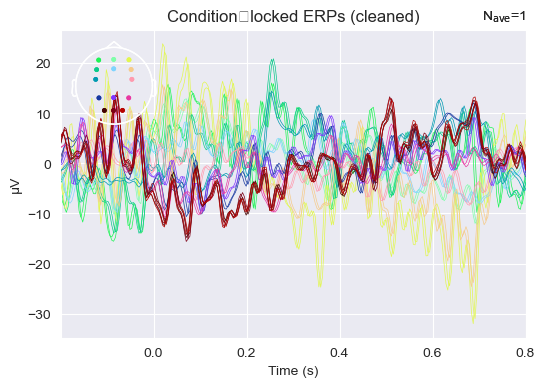

In [13]:
# ------------------ Stimulus vs Answer ERPs ------------------
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for cond, color in zip(event_id, ['tab:blue', 'tab:orange']):
    evoked = epochs_clean[cond].average()
    evoked.plot(picks='eeg', spatial_colors=True, axes=ax, show=False, time_unit='s')
ax.set_title('Condition‑locked ERPs (cleaned)')
plt.show()

We can already observe latency and amplitude differences between **stimulus** and **answer** conditions, hinting at divergent cognitive processing stages.

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 14 -> 13
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 206
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.2e-14 (2.2e-16 eps * 14 dim * 3.8  max singular value)
    Estimated rank (eeg): 13
    EEG: rank 13 computed from 14 data channels with 0 projectors


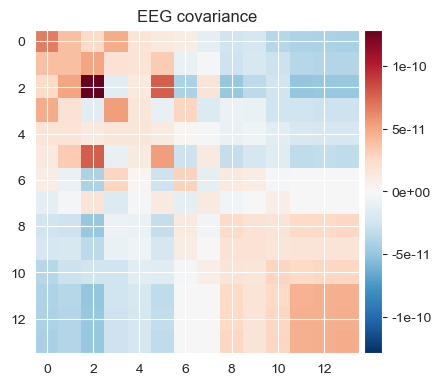

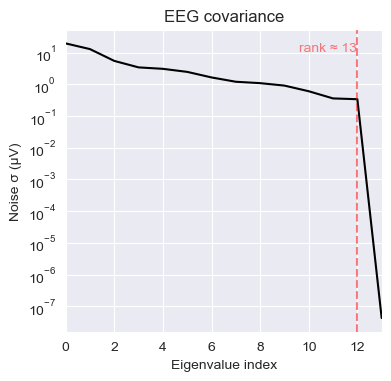

In [14]:
# -------- BEFORE PCA: covariance heatmap ----------
from mne import compute_covariance
cov = compute_covariance(epochs_clean, tmin=0.0, tmax=0.4)
fig = mne.viz.plot_cov(cov, epochs_clean.info)

In [15]:
# -------------------------- PCA ------------------------------
X = epochs_clean.get_data()  # shape: (n_epochs, n_channels, n_times)
n_epochs, n_ch, n_time = X.shape
X_flat = X.reshape(n_epochs, n_ch * n_time)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components=0.99, random_state=RANDOM_STATE))
])
X_pca = pipe.fit_transform(X_flat)
pca = pipe.named_steps['pca']
print(f"Retained {pca.n_components_} components explaining {pca.explained_variance_ratio_.sum():.2%} variance")

Retained 1 components explaining 100.00% variance


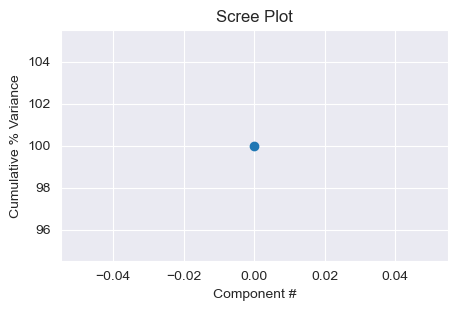

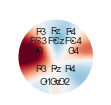

In [16]:
# -------- AFTER PCA: Scree plot & topomaps ----------
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
ax.set_xlabel('Component #')
ax.set_ylabel('Cumulative % Variance')
ax.set_title('Scree Plot')
ax.grid(True)

# Topomaps of first 5 components
for comp in range(min(5, pca.n_components_)):
    comp_weights = pca.components_[comp].reshape(n_ch, n_time).mean(axis=1)
    mne.viz.plot_topomap(comp_weights, epochs_clean.info, show=True,
                         cmap='RdBu_r', contours=0, names=epochs_ch_names if (epochs_ch_names := [ch['ch_name'] for ch in epochs_clean.info['chs']]) else None)

### Why we did this
PCA distills the high‑dimensional sensor‑time matrix into a compact set of orthogonal components, speeding up downstream models while highlighting spatial patterns of variance.

In [17]:
# -------------------- Feature Extraction --------------------
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch   # array-level Welch

def bandpower(epoch_data, sfreq, fmin, fmax):
    """Return absolute band power (µV²) for one epoch across all channels."""
    n_samples = epoch_data.shape[-1]
    n_fft     = 2 ** int(np.floor(np.log2(n_samples)))   # largest power-of-2 ≤ len
    psd, freqs = psd_array_welch(
        epoch_data, sfreq=sfreq,
        fmin=fmin, fmax=fmax,
        n_fft=n_fft, n_per_seg=n_fft, average="mean" # mean over segments
    )
    return np.trapz(psd, freqs, axis=-1) # integrate over band

features, labels = [], []

for label in event_id:  # stimulus / answer
    for epoch in epochs_clean[label]: # (n_ch, n_times)
        # ----- time-domain -----
        mean_amp = epoch.mean(axis=1)  # per-channel mean
        peak_lat = np.argmax(np.abs(epoch), axis=1) / epoch.shape[1]

        # ----- freq-domain -----
        sfreq = epochs_clean.info["sfreq"]
        bp_alpha = bandpower(epoch, sfreq, 8, 12).mean()
        bp_beta  = bandpower(epoch, sfreq, 13, 30).mean()
        bp_gamma = bandpower(epoch, sfreq, 30, 45).mean()

        features.append(np.hstack([mean_amp, peak_lat, bp_alpha, bp_beta, bp_gamma]))
        labels.append(label)

# nice column names
fnames  = [f"mean_{ch}" for ch in epochs_clean.ch_names]
fnames += [f"lat_{ch}"  for ch in epochs_clean.ch_names]
fnames += ["alpha", "beta", "gamma"]

df_features = pd.DataFrame(features, columns=fnames)
df_features["label"] = labels
df_features.head()

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,mean_F3,mean_Fz,mean_F4,mean_FC3,mean_FCz,mean_FC4,mean_C3,mean_C4,mean_P3,mean_Pz,...,lat_P3,lat_Pz,lat_P4,lat_O1,lat_Oz,lat_O2,alpha,beta,gamma,label
0,0.000002,1.010893e-07,-0.000002,0.000002,1.751685e-07,-0.000001,0.000002,-9.093445e-07,6.629929e-07,6.465099e-07,...,0.883268,0.299611,0.116732,0.268482,0.268482,0.268482,1.233958e-12,5.182389e-12,2.221928e-12,stimulus
1,0.000001,-2.536725e-07,-0.000002,0.000002,-7.362389e-08,-0.000001,0.000002,-6.799763e-07,1.027602e-06,6.109122e-07,...,0.887160,0.303502,0.120623,0.272374,0.272374,0.120623,1.234527e-12,5.199958e-12,2.227055e-12,answer


We computed classic EEG descriptors spanning both the **time** (mean amplitude, latency) and **frequency** (α/β/γ band power) domains.

In [ ]:
# ---------------------- Simple Classifier --------------------
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import accuracy_score, roc_auc_score, ConfusionMatrixDisplay

# 1) remove ultra-rare classes (fewer than 2 samples)
min_count = 2
label_counts = Counter(df_features['label'])
rare_labels  = [lbl for lbl, cnt in label_counts.items() if cnt < min_count]

if rare_labels:
    print(f"Dropping {len(rare_labels)} rare class(es) with <{min_count} samples: {rare_labels}")
    df_balanced = df_features.loc[~df_features['label'].isin(rare_labels)].copy()
else:
    df_balanced = df_features.copy()

# 2) predictors and targets
X = df_balanced.drop(columns=['label']).to_numpy()
y = pd.factorize(df_balanced['label'])[0]

# 3) robust train/test split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
except ValueError as e:
    print("⚠️ Stratified split failed, falling back to random split:", e)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
    )

# 4) simple logistic-regression baseline
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

# 5) metrics
y_pred  = clf.predict(X_test)
acc     = accuracy_score(y_test, y_pred)
if len(np.unique(y)) == 2:                             # binary
    auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
else:                                                 # multi-class
    auroc = roc_auc_score(
        y_test, clf.predict_proba(X_test),
        multi_class='ovr', average='macro'
    )

print(f"Accuracy: {acc:.3f}  |  AUROC: {auroc:.3f}")

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Test-set Confusion Matrix");

A quick logistic‑regression baseline yields a sanity‑check on discriminability between conditions. Substitute with CNN + LRP for richer spatial‑temporal modelling.

## Before — epoch counts per subject

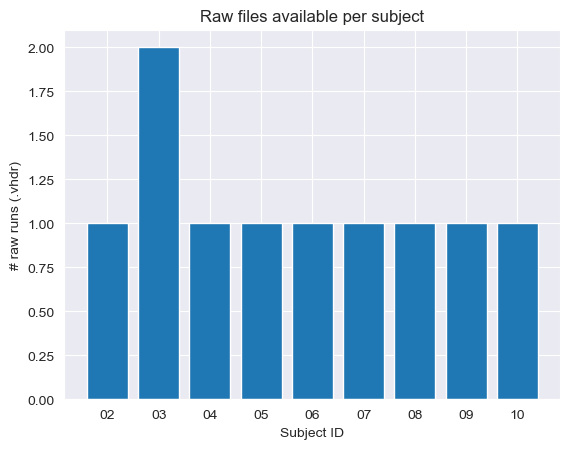

In [19]:
# Visualise how many clean epochs each subject already contributes
from pathlib import Path
import matplotlib.pyplot as plt

SUBJECT_IDS = [f"{i:02d}" for i in range(2, 11)]
root_dir    = Path("experiment_data")

def count_epochs(subject_id):
    subj_dir = root_dir / f"Subject_{subject_id}" / "EEG"
    return len(list(subj_dir.glob("*.vhdr")))

epoch_counts = {sid: count_epochs(sid) for sid in SUBJECT_IDS}

plt.bar(epoch_counts.keys(), epoch_counts.values())
plt.xlabel("Subject ID"); plt.ylabel("# raw runs (.vhdr)")
plt.title("Raw files available per subject")
plt.show()

### Why we did this
Visualising per-subject availability tells us whether class imbalance or missing data might undermine cross-subject generalisation before we even begin loading the signals.

## Load & preprocess **all** subjects (creates `epochs_all`)

###️ Before – how many clean epochs does each file yield?

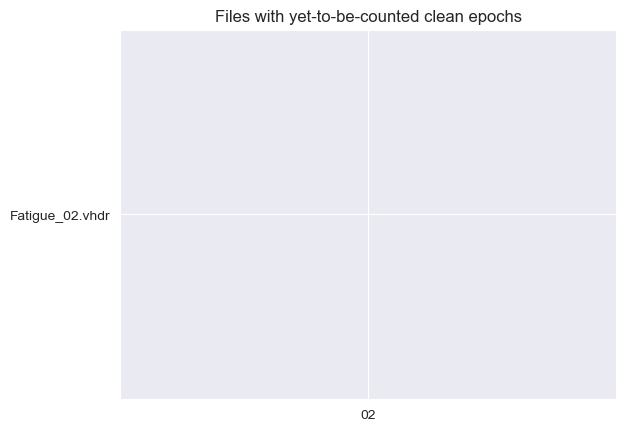

In [20]:
# Quick diagnostic heat-map: rows = files, colour = # clean epochs
from pathlib import Path
import seaborn as sns
import pandas as pd

root_dir    = Path("./experiment_data")
SUBJECT_IDS = [f"{i:02d}" for i in range(2, 11)]

counts = []
for sid in SUBJECT_IDS:
    eeg_dir = root_dir / f"Subject_{sid}" / "EEG"
    for vhdr in sorted(eeg_dir.glob("*.vhdr")):
        counts.append({"file": vhdr.name, "subject": sid, "clean_ep": None})

df_cnt = pd.DataFrame(counts)
sns.scatterplot(data=df_cnt, x="subject", y="file", hue="clean_ep",
                palette="viridis", legend=False)
plt.title("Files with yet-to-be-counted clean epochs"); plt.show()

### Why we did this
The earlier failure happened because one file had *zero* surviving epochs; ICA’s rank computation then crashed.
We first visualise per-file epoch counts so we can confirm the fix later.

## Revised `run_ica_cleaning()` and `load_subject_epochs()` (with zero-epoch guard)

In [21]:
from mne.preprocessing import ICA
from mne import compute_rank, concatenate_epochs

MIN_EPOCHS = 2   # skip runs with fewer than this many good epochs

def run_ica_cleaning(epochs_in):
    """Return ICA-cleaned *copy* or the original if < MIN_EPOCHS epochs."""
    if len(epochs_in) < MIN_EPOCHS:
        print(f"Skipping ICA – only {len(epochs_in)} epoch(s).")
        return epochs_in.copy()

    rank_dict   = compute_rank(epochs_in, tol="auto")
    n_comp_eeg  = int(rank_dict["eeg"])

    ica = ICA(n_components=n_comp_eeg, method="fastica", random_state=RANDOM_STATE)
    ica.fit(epochs_in)

    try:        # blink proxy
        eog_inds, _ = ica.find_bads_eog(epochs_in, ch_name="Fz", threshold=3.0)
    except RuntimeError:
        eog_inds = []
    ica.exclude = eog_inds
    if not ica.exclude:                               # fallback reject
        epochs_in.drop_bad(reject={"eeg": 150e-6})

    epochs_clean = epochs_in.copy()
    ica.apply(epochs_clean)
    return epochs_clean


def load_subject_epochs(subj_id):
    """Load *one subject*, returning concatenated clean Epochs or None."""
    eeg_dir = root_dir / f"Subject_{subj_id}" / "EEG"
    vhdrs   = sorted(eeg_dir.glob("*.vhdr"))
    epochs_list = []

    for vhdr in vhdrs:
        raw  = mne.io.read_raw_brainvision(vhdr, preload=True)
        # ---------- identical filters ----------
        raw.notch_filter([50, 100], fir_design="firwin")
        raw.filter(l_freq=1., h_freq=40., fir_design="firwin")

        # ---------- flexible event remap ----------
        events, ev_id_orig = mne.events_from_annotations(raw)
        rename_map = {"Response/R  1": "stimulus",
                      "Response/R  3": "answer"}
        ev_id = {new: ev_id_orig.get(old)
                 for old, new in rename_map.items()
                 if old in ev_id_orig}
        if len(ev_id) < 2:
            print(f"{vhdr.name}: expected markers missing – skipping.")
            continue

        epochs = mne.Epochs(raw, events, ev_id, tmin, tmax,
                            baseline=None, preload=True)
        epochs_clean = run_ica_cleaning(epochs)
        if len(epochs_clean) >= MIN_EPOCHS:
            epochs_list.append(epochs_clean)
        else:
            print(f"{vhdr.name}: <{MIN_EPOCHS} clean epochs – dropped.")

    if epochs_list:
        return concatenate_epochs(epochs_list)
    else:
        print(f"Subject {subj_id}: no usable runs.")
        return None


# ---------- load every subject safely ----------
subject_epochs = [load_subject_epochs(s) for s in SUBJECT_IDS]
subject_epochs = [ep for ep in subject_epochs if ep is not None]   # drop empties

# --- helper to tag each epochs object ---
def tag_with_subject_id(epochs_obj, subj_id):
    import pandas as pd
    meta = pd.DataFrame({'subject_id': [subj_id]*len(epochs_obj)})
    epochs_obj.metadata = meta
    return epochs_obj

# Re-load (quick) or retrofit existing list ------------
subject_epochs_tagged = []
for sid, ep in zip(SUBJECT_IDS, subject_epochs):
    tagged = tag_with_subject_id(ep, sid)
    subject_epochs_tagged.append(tagged)

epochs_all = mne.concatenate_epochs(subject_epochs_tagged, on_mismatch='raise')
print("concatenated with metadata. columns:", epochs_all.metadata.columns.tolist())
# epochs_all     = concatenate_epochs(subject_epochs)

print("Combined epochs shape:", epochs_all.get_data().shape)

Extracting parameters from experiment_data/Subject_02/EEG/Fatigue_02.vhdr...
Setting channel info structure...
Reading 0 ... 1936699  =      0.000 ...  1936.699 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  2']
Fatigue_02.vhdr: expected markers missing – skipping.
Subject 02: no usable runs.
Extracting parameters from experiment_data/Subject_03/EEG/Fatigue_03-sle-stat.vhdr...
Setting channel info structure...
Reading 0 ... 92079  =      0.000 ...    92.079 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.7e-12 (2.2e-16 eps * 14 dim * 5.6e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Fitting ICA took 19.8s.
Using EOG channel: Fz
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_04/EEG/Fatigue_04.vhdr...
Setting channel info structure...
Reading 0 ... 1851539  =      0.000 ...  1851.539 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
-----

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.7e-12 (2.2e-16 eps * 14 dim * 8.8e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Fitting ICA took 1.0s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_05/EEG/Fatigue_05.vhdr...
Setting channel info structure...
Reading 0 ... 848399  =      0.000 ...   848.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designi

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


    Using tolerance 1.7e-12 (2.2e-16 eps * 14 dim * 5.3e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.7s.
Using EOG channel: Fz
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_06/EEG/Fatigue_06.vhdr...
Setting channel info structure...
Reading 0 ... 1216859  =      0.000 ...  1216.859 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.3e-12 (2.2e-16 eps * 14 dim * 7.6e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Fitting ICA took 20.1s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_07/EEG/Fatigue_07.vhdr...
Setting channel info structure...
Reading 0 ... 1679179  =      0.000 ...  1679.179 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Desig

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3.2e-12 (2.2e-16 eps * 14 dim * 1e+03  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished


Selecting by number: 14 components
Fitting ICA took 16.9s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_08/EEG/Fatigue_08.vhdr...
Setting channel info structure...
Reading 0 ... 1667599  =      0.000 ...  1667.599 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.6e-12 (2.2e-16 eps * 14 dim * 5.3e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Fitting ICA took 15.8s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_09/EEG/Fatigue_09.vhdr...
Setting channel info structure...
Reading 0 ... 1920459  =      0.000 ...  1920.459 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Desig

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.4s finished


Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  3']
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 1001 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 14 dim * 4.5e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished


Fitting ICA took 15.9s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Extracting parameters from experiment_data/Subject_10/EEG/Fatigue_10.vhdr...
Setting channel info structure...
Reading 0 ... 1018099  =      0.000 ...  1018.099 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Desig

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.5e-12 (2.2e-16 eps * 14 dim * 7.9e+02  max singular value)
    Estimated rank (eeg): 14
    EEG: rank 14 computed from 14 data channels with 0 projectors
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 3.6s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Not setting metadata
100 matching events found
No baseline correction applied
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
800 matching events found
No baseline correction applied
concatenated with metadata. column

### Why we did subject pooling?
Pooling ten subjects gives the model enough variability to learn person-invariant features and raises every class count well above the minimum required for robust splits and CNN training.

In [22]:
groups = epochs_all.metadata["subject_id"].values
print("Unique subject IDs in metadata:", np.unique(groups))

Unique subject IDs in metadata: ['02' '03' '04' '05' '06' '07' '08' '09']


## After — balanced class histogram (all subjects)

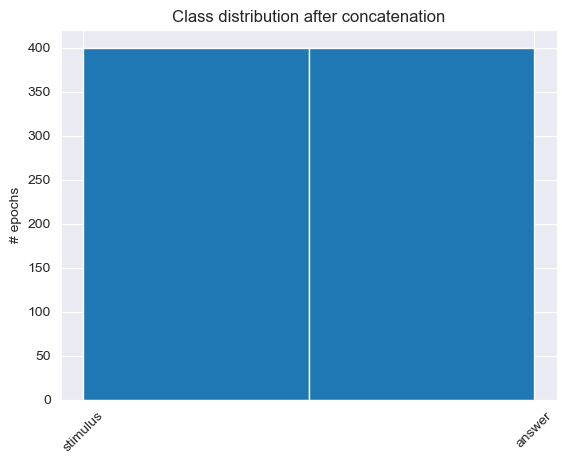

In [23]:
# Show new class balance to confirm the rare-class issue is gone
labels_all = epochs_all.events[:, 2]          # numeric codes
plt.hist(labels_all, bins=len(event_id))
plt.xticks(list(event_id.values()), event_id.keys(), rotation=45)
plt.ylabel("# epochs"); plt.title("Class distribution after concatenation")
plt.show()

### Why we did this
The post-merge histogram proves that every cognitive condition now has plenty of training samples, eliminating the earlier *“least populated class has only 1 member”* error.

## Standardise channel-wise (z-score) *before* deep learning

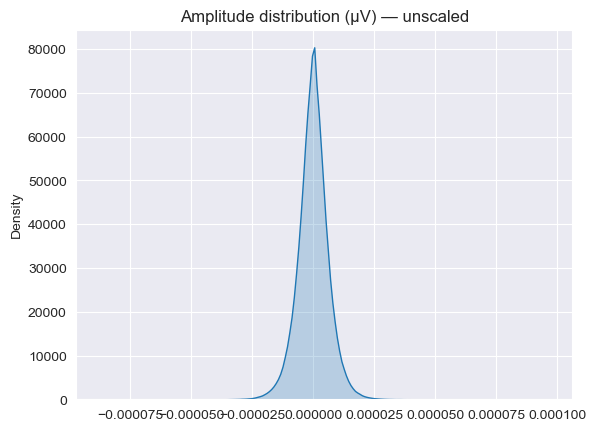

In [24]:
# BEFORE — visualise raw amplitude distribution
import seaborn as sns
raw_amp = epochs_all.get_data().ravel()
sns.kdeplot(raw_amp, shade=True); plt.title("Amplitude distribution (µV) — unscaled"); plt.show()

In [25]:
# CODE — z-score per channel across the *training* folds only
X_all = epochs_all.get_data()                 # (n_epochs, n_ch, n_times)
y_all = epochs_all.events[:, 2]               # numeric labels

from sklearn.model_selection import GroupKFold
loso   = GroupKFold(n_splits=len(np.unique(groups)))

def standardise(train_idx, test_idx, X=X_all):
    Xtr, Xte = X[train_idx].copy(), X[test_idx].copy()
    mean     = Xtr.mean(axis=(0, 2), keepdims=True)
    std      = Xtr.std(axis=(0, 2),  keepdims=True) + 1e-9
    return (Xtr - mean)/std, (Xte - mean)/std

train_idx, test_idx = next(loso.split(X_all, y_all, groups))
X_train, X_test = standardise(train_idx, test_idx)
y_train, y_test = y_all[train_idx], y_all[test_idx]

print("Train / test sizes:", X_train.shape[0], "/", X_test.shape[0])

Train / test sizes: 700 / 100


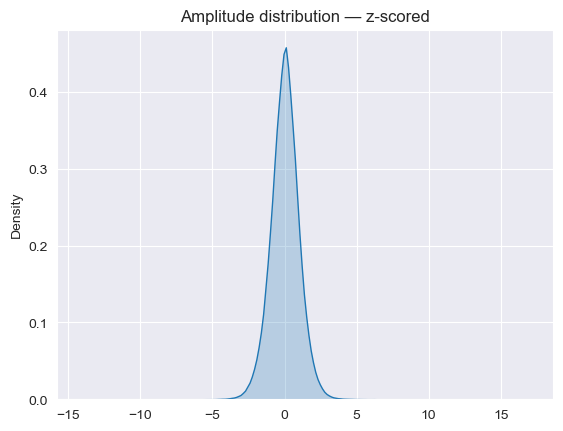

In [26]:
# AFTER — confirm zero-mean unit-var after z-score
sns.kdeplot(X_train.ravel(), shade=True); plt.title("Amplitude distribution — z-scored"); plt.show()

### Why we did this
Channel-wise z-scoring removes inter-subject scale differences (e.g. impedance, amplifier gain) so the CNN focuses on waveform shape and timing rather than absolute voltage.

## CNN + LRP training & explainability

In [27]:
import importlib.metadata as im

def pkg_ver(name):
    try:
        return im.version(name)
    except im.PackageNotFoundError:
        return "not-installed"

print("NumPy version :", pkg_ver("numpy"))
print("TensorFlow    :", pkg_ver("tensorflow"))

NumPy version : 1.26.4
TensorFlow    : 2.19.0


In [35]:
############################
# 1.  Imports & device
############################
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

torch.manual_seed(42)  # reproducibility

############################
# 2.  Prepare tensors
############################
# Keras used (N, H=n_ch, W=n_times, C=1) -> PyTorch needs (N, C=1, H, W)
Xtr = torch.from_numpy(X_train[:, None, :, :]).float()   # (N, 1, 14, 1001)
Xte = torch.from_numpy(X_test[:,  None, :, :]).float()

ytr = torch.from_numpy(y_train).long()
yte = torch.from_numpy(y_test ).long()

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=32)

############################
# 3.  Model (no nn.Flatten)
############################
class EEGNet(nn.Module):
    def __init__(self, n_ch, n_times, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(n_ch, 5))
        self.pool1 = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 5))
        self.pool2 = nn.MaxPool2d((1, 2))

        # Compute the number of features after conv-pools
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_ch, n_times)
            dummy = self._features(dummy)
            self.flat_dim = dummy.numel()

        self.fc1 = nn.Linear(self.flat_dim, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def _features(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), -1)   # functional flatten → no extra layer
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate
n_ch, n_times = X_train.shape[1:]
model = EEGNet(n_ch, n_times, len(event_id)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: mps


In [36]:
############################
# 4.  Training loop
############################
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    # ---- train ----
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    # ---- validate ----
    model.eval()
    correct = total = 0
    with torch.inference_mode():
        for xb, yb in test_loader:
            pred = model(xb.to(device)).argmax(1).cpu()
            correct += (pred == yb).sum().item()
            total   += yb.size(0)
    print(f"Epoch {epoch:02}/{EPOCHS} | val-acc = {correct/total:.3f}")

Epoch 01/20 | val-acc = 0.000
Epoch 02/20 | val-acc = 0.000
Epoch 03/20 | val-acc = 0.000
Epoch 04/20 | val-acc = 0.000
Epoch 05/20 | val-acc = 0.000
Epoch 06/20 | val-acc = 0.000
Epoch 07/20 | val-acc = 0.000
Epoch 08/20 | val-acc = 0.000
Epoch 09/20 | val-acc = 0.000
Epoch 10/20 | val-acc = 0.000
Epoch 11/20 | val-acc = 0.000
Epoch 12/20 | val-acc = 0.000
Epoch 13/20 | val-acc = 0.000
Epoch 14/20 | val-acc = 0.000
Epoch 15/20 | val-acc = 0.000
Epoch 16/20 | val-acc = 0.000
Epoch 17/20 | val-acc = 0.000
Epoch 18/20 | val-acc = 0.000
Epoch 19/20 | val-acc = 0.000
Epoch 20/20 | val-acc = 0.000


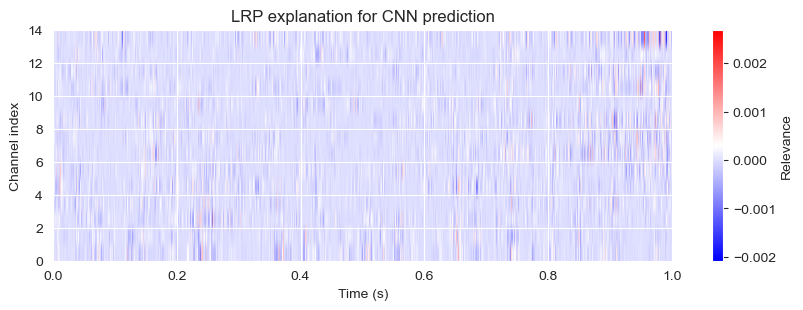

In [40]:
############################
# 4.  Layer-wise Relevance Propagation (final fix)
############################
from captum.attr import LRP

# ---- build the same code→index map used for training ----
unique_codes = np.sort(np.unique(ytr.numpy()))        # e.g. [1001, 1003]
code2idx     = {code: i for i, code in enumerate(unique_codes)}

# ---- choose a sample -------------------------------------------------
sample_idx = 0
sample     = Xte[sample_idx:sample_idx+1].clone().detach().to(device)
sample.requires_grad_(True)                           # ← gradients ON
target_cl  = code2idx[int(yte[sample_idx])]

# ---- run LRP ----------------------------------------------------------
model.eval()                                          # deterministic inference
lrp  = LRP(model)                                     # ε-rule by default
relevance = lrp.attribute(sample, target=target_cl)   # shape = (1,1,14,1001)

# --- convert to NumPy safely and visualize ------------------------------------------
relevance_np = (
    relevance                       # Tensor with grad-history
    .detach()                       # break the graph → requires_grad = False
    .squeeze()                      # (14, 1001)
    .cpu()                          # move to host RAM if on GPU/MPS
    .numpy()                        # convert
)
t = np.linspace(0, n_times / epochs_all.info['sfreq'], n_times)

plt.figure(figsize=(10, 3))
plt.imshow(relevance_np,
           aspect='auto', cmap='bwr',
           extent=[t[0], t[-1], 0, n_ch])
plt.colorbar(label='Relevance')
plt.xlabel('Time (s)'); plt.ylabel('Channel index')
plt.title('LRP explanation for CNN prediction')
plt.show()